**Regression of Used Car Prices**

Goal

**To predict the price of used cars based on various attributes**

Here is a detailed description of each some fields in the dataset:

**model_year:**
The year the vehicle model was manufactured. It is mapped directly to the model_year in the competition 
dataset and includes all combinations of years present. The age of the car typically affects its resale value.

**brand:**
The manufacturer of the vehicle. This field matches the brand in the competition dataset. Different brands have
varying resale values based on their reliability, reputation, and demand.

**model:**
The specific model of the vehicle produced by the brand. This field is directly mapped to the model in the 
competition dataset. Different models, even within the same brand, can have significant variations in price.

**type:**
The classification of the vehicle, such as SUV, Coupe, Sedan, Convertible, or Van. Vehicle type influences 
the price as it relates to the utility, market demand, and intended use.

**miles_per_gallon:**
The fuel efficiency of the vehicle, measured in miles per gallon (MPG). Higher fuel efficiency is often 
associated with higher value due to lower operational costs.

**premium_version:**
A binary field indicating whether the car is a premium version (1) or not (0). Premium versions may include 
luxury features or higher-end specifications, which typically raise the vehicle's value.

**msrp:**
The Manufacturer's Suggested Retail Price (MSRP) when the car was new. This is a strong indicator of the car's
original value and influences its depreciation rate and current market value.

**collection_car:**
A binary field indicating whether the car is considered a "collector's item" (1) or not (0). Collector cars 
tend to retain or increase their value over time due to rarity or historical significance.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils.validation import check_is_fitted
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

df = pd.read_csv("Data/train.csv")

df_ext = pd.read_csv("Data/extended_data.csv")

df.head(3)

df_ext.head(3)

modified_data = pd.merge(df, df_ext, on=["model_year", "brand", "model"], how = "inner")

modified_data.head()

modified_data.to_csv("modified_data.csv", index=False)

In [2]:
df = pd.read_csv("Data/modified_data.csv")

In [3]:
df.set_index("id", inplace=True)

**Inspecting the Dataset**

In [4]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,type,miles_per_gallon,premium_version,msrp,collection_car
id,,,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,Hatchback,30.0,1,23000.0,0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,Sedan,18.0,0,38500.0,0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,Pickup,14.0,0,29335.0,0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,Sedan,15.0,1,70000.0,0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,Minivan,19.0,0,33900.0,0


In [5]:
df.drop(columns="clean_title", inplace=True)

In [6]:
df["accident"].nunique()

2

In [7]:
df["collection_car"].nunique()

2

In [8]:
df["premium_version"].nunique()

2

In [9]:
df["fuel_type"].nunique()

7

In [10]:
df.dropna(how="any", inplace=True)

In [11]:
df["miles_per_gallon"] = df["miles_per_gallon"].astype("int64")
df["msrp"] = df["msrp"].astype("int64")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181052 entries, 0 to 188532
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   brand             181052 non-null  object
 1   model             181052 non-null  object
 2   model_year        181052 non-null  int64 
 3   milage            181052 non-null  int64 
 4   fuel_type         181052 non-null  object
 5   engine            181052 non-null  object
 6   transmission      181052 non-null  object
 7   ext_col           181052 non-null  object
 8   int_col           181052 non-null  object
 9   accident          181052 non-null  object
 10  price             181052 non-null  int64 
 11  type              181052 non-null  object
 12  miles_per_gallon  181052 non-null  int64 
 13  premium_version   181052 non-null  int64 
 14  msrp              181052 non-null  int64 
 15  collection_car    181052 non-null  int64 
dtypes: int64(7), object(9)
memory usage: 23.5+ 

**Cleaning and Exploring the Dataset**

In [13]:
corr = df.select_dtypes("number").drop(columns="price").corr()

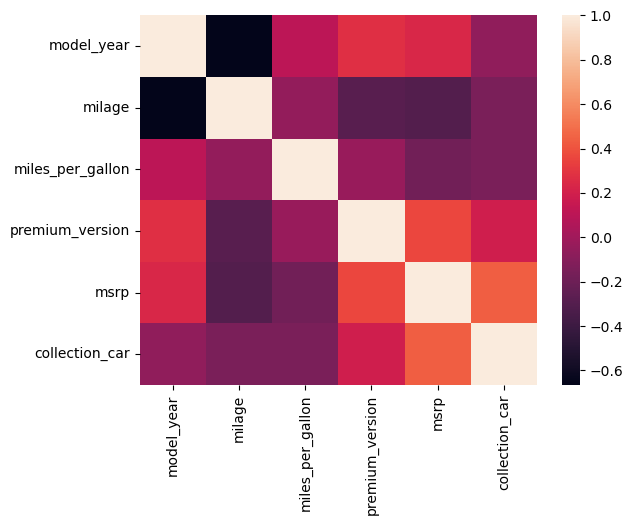

In [14]:
sns.heatmap(corr);

In [15]:
df["price"].corr(df["msrp"])

0.2533269095507713

In [16]:
df["price"].corr(df["collection_car"])

0.1422607035015138

In [17]:
df["price"].corr(df["premium_version"])

0.12648813670716813

In [18]:
df.drop(columns = ["collection_car","premium_version"], inplace=True)

In [19]:
df.select_dtypes("object").nunique()

brand             57
model           1888
fuel_type          7
engine          1108
transmission      52
ext_col          319
int_col          156
accident           2
type               9
dtype: int64

In [20]:
df.drop(columns = ["model","engine","accident","type","fuel_type","msrp","miles_per_gallon"], inplace = True)

In [21]:
df.tail()

,brand,model_year,milage,transmission,ext_col,int_col,price
id,,,,,,,
188528,Cadillac,2017,49000,Transmission w/Dual Shift Mode,White,Beige,27500
188529,Mercedes-Benz,2018,28600,8-Speed A/T,White,Black,30000
188530,Mercedes-Benz,2021,13650,7-Speed A/T,White,Black,86900
188531,Audi,2022,13895,1-Speed Automatic,Daytona Gray Pearl Effect,Black,84900
188532,Porsche,2016,59500,Transmission w/Dual Shift Mode,White,Black,28995


**Creating my Feature Matrix and Target Vector**

In [22]:
target = "price"
feature = ["brand","model_year","milage","transmission","ext_col","int_col"]
y_train = df[target]
X_train = df[feature]

**Dividing my Data into Training and Validation Set**

In [23]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,y_train,test_size = 0.3,random_state=42
)

**Calculating my Baseline MAE**

In [24]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
print("Mean car price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline).round(2))

Mean car price: 43257.81
Baseline MAE: 28822.32


**Building my Model**

In [25]:
model = make_pipeline(
    OneHotEncoder (use_cat_names = True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['brand', 'transmission', 'ext_col',
                                     'int_col'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

**Testing my Model on My Training Data**

In [26]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training).round(2))

Training MAE: 22210.24


**Testing my Model on my Validation Data**

In [27]:
y_pred_val = model.predict(X_val)
MAE = mean_absolute_error(y_val, y_pred_val)
MSE = mean_squared_error(y_val, y_pred_val)
r2 = model.score(X_val, y_val)
print("Validation MAE:", MAE.round(2))
print("Validation MSE:", MSE.round(2))
print("Validation R2:", r2)

Validation MAE: 22481.44
Validation MSE: 5985874636.59
Validation R2: 0.10760286702330624


**From the results above my model improved upon the baseline, indicating that it captures
meaningful patterns. When it comes to the close proximity of the training and validation
MAEs suggests that my model is neither overfitting nor underfitting and is likely 
well-tuned for the data.**

**Using my Model to Predict Prices of Used Cars based on Various Attributes**

In [28]:
test = pd.read_csv("Data/test.csv")

In [29]:
X_test = test[["brand", "model_year", "milage","transmission", "ext_col", "int_col"]]

In [30]:
test_id = test[["id"]]

In [31]:
test_id

,id
0,188533
1,188534
2,188535
3,188536
4,188537
...,...
125685,314218
125686,314219
125687,314220
125688,314221


In [32]:
test_pred = pd.Series(model.predict(X_test),name="Price")

In [33]:
test_pred = test_pred.astype("int64")

In [34]:
test_pred_df = test_pred.to_frame()
test_pred_df

,Price
0,27538
1,67100
2,55945
3,39784
4,39263
...,...
125685,37997
125686,47049
125687,25750
125688,16243


In [35]:
Predicted_price = pd.concat([test_id,test_pred_df], axis=1)
Predicted_price.set_index("id", inplace=True)

In [36]:
Predicted_price.head()

,Price
id,
188533,27538
188534,67100
188535,55945
188536,39784
188537,39263


In [47]:
Predicted_price.to_csv("Predicted_price.csv", index=True)